In [ ]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# CONFIGURATION - Based on experimentation results
# ============================================================================
BEST_CHANGEPOINT_SCALE = 0.1  # Flexible won in testing
USE_FLOOR = False  # No Floor performed equally well
USE_HOLIDAYS = True

# ============================================================================
# LOAD DATA
# ============================================================================
train = pd.read_csv('/Users/nikola/Python/KaggleCompetition/data/train/pre_owned_house_transactions.csv')
sample_submission = pd.read_csv('/Users/nikola/Python/KaggleCompetition/data/sample_submission.csv')

train['month'] = pd.to_datetime(train['month'])

print(f"Train data: {len(train)} rows, {train['sector'].nunique()} sectors")
print(f"Train period: {train['month'].min()} to {train['month'].max()}")
print(f"Sample submission shape: {sample_submission.shape}")
print(f"\nSample submission format:")
print(sample_submission.head())

# ============================================================================
# PARSE SUBMISSION IDs TO EXTRACT MONTH AND SECTOR
# ============================================================================
def parse_submission_id(id_str):
    """
    Parse ID like "2024 Aug_sector 1" into month and sector
    Returns: (datetime, sector_name)
    """
    parts = id_str.split('_')
    date_str = parts[0]  # "2024 Aug"
    sector = '_'.join(parts[1:])  # "sector 1"
    
    # Parse date
    month = pd.to_datetime(date_str, format='%Y %b')
    
    return month, sector

# Parse all IDs to understand what we need to predict
sample_submission['month'] = sample_submission['id'].apply(lambda x: parse_submission_id(x)[0])
sample_submission['sector'] = sample_submission['id'].apply(lambda x: parse_submission_id(x)[1])

print(f"\nParsed submission:")
print(f"  Unique months: {sample_submission['month'].nunique()}")
print(f"  Date range: {sample_submission['month'].min()} to {sample_submission['month'].max()}")
print(f"  Unique sectors: {sample_submission['sector'].nunique()}")
print(f"  Sectors: {sorted(sample_submission['sector'].unique())[:5]}... (showing first 5)")

# ============================================================================
# PROPHET FORECASTING FUNCTION
# ============================================================================
def forecast_sector_prophet(sector_id, train_df, target_dates,
                           changepoint_scale=0.1, use_floor=False):
    """
    Forecast a single sector using Prophet for specific dates
    
    Args:
        sector_id: Sector identifier (e.g., "sector 1")
        train_df: Training data
        target_dates: List of datetime objects to predict
        changepoint_scale: Prophet parameter
        use_floor: Whether to use floor constraint
    
    Returns:
        Array of predictions
    """
    sector_train = train_df[train_df['sector'] == sector_id].copy()
    
    # Check for sufficient data
    if len(sector_train) < 12:
        return np.zeros(len(target_dates))
    
    # Prepare data for Prophet
    prophet_train = sector_train[['month', 'amount_pre_owned_house_transactions']].copy()
    prophet_train.columns = ['ds', 'y']
    prophet_train = prophet_train.dropna()
    
    # Check if all values are zero or near-zero
    if len(prophet_train) == 0 or prophet_train['y'].max() < 1:
        return np.zeros(len(target_dates))
    
    # Set floor if requested
    if use_floor:
        floor_value = prophet_train['y'].min() * 0.1
        prophet_train['floor'] = floor_value
    
    # Create Chinese New Year holidays
    chinese_holidays = pd.DataFrame({
        'holiday': 'chinese_new_year',
        'ds': pd.to_datetime([
            '2019-02-05', '2020-01-25', '2021-02-12', 
            '2022-02-01', '2023-01-22', '2024-02-10', 
            '2025-01-29'
        ]),
        'lower_window': -1,
        'upper_window': 1,
    })
    
    # Initialize and fit model
    model = Prophet(
        holidays=chinese_holidays if USE_HOLIDAYS else None,
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        changepoint_prior_scale=changepoint_scale,
        growth='linear',
    )
    
    try:
        model.fit(prophet_train)
    except Exception as e:
        print(f"  ERROR fitting {sector_id}: {e}")
        return np.zeros(len(target_dates))
    
    # Create future dataframe for target dates
    future = pd.DataFrame({'ds': target_dates})
    
    if use_floor:
        future['floor'] = floor_value
    
    # Predict
    forecast = model.predict(future)
    predictions = forecast['yhat'].values
    
    # Ensure non-negative predictions
    predictions = np.clip(predictions, 0, None)
    
    return predictions

# ============================================================================
# GENERATE PREDICTIONS FOR ALL SECTORS AND DATES
# ============================================================================
print("\n" + "="*60)
print("GENERATING PREDICTIONS")
print("="*60)

# Get unique sectors from submission
all_sectors = sorted(sample_submission['sector'].unique())
print(f"\nProcessing {len(all_sectors)} sectors...")

# Create predictions dictionary
predictions_dict = {}

for i, sector in enumerate(all_sectors, 1):
    if i % 10 == 0:
        print(f"Progress: {i}/{len(all_sectors)} sectors completed")
    
    # Get target dates for this sector
    sector_rows = sample_submission[sample_submission['sector'] == sector]
    target_dates = sorted(sector_rows['month'].unique())
    
    # Special handling for sector 95 (no data)
    if sector == 'sector 95':
        predictions = np.zeros(len(target_dates))
    else:
        predictions = forecast_sector_prophet(
            sector,
            train,
            target_dates,
            changepoint_scale=BEST_CHANGEPOINT_SCALE,
            use_floor=USE_FLOOR
        )
    
    # Store predictions with corresponding dates
    for date, pred in zip(target_dates, predictions):
        # Create the ID format: "YYYY MMM_sector X"
        # Convert to pandas Timestamp to use strftime
        date_str = pd.Timestamp(date).strftime('%Y %b')
        submission_id = f"{date_str}_{sector}"
        predictions_dict[submission_id] = pred

print(f"\nCompleted! Generated {len(predictions_dict)} predictions")

# ============================================================================
# CREATE SUBMISSION FILE
# ============================================================================
submission = sample_submission[['id']].copy()
submission['new_house_transaction_amount'] = submission['id'].map(predictions_dict)

# Check for any missing predictions
missing = submission['new_house_transaction_amount'].isna().sum()
if missing > 0:
    print(f"\nWARNING: {missing} predictions are missing - filling with 0")
    submission['new_house_transaction_amount'].fillna(0, inplace=True)

# Save submission
submission.to_csv('/Users/nikola/Python/KaggleCompetition/output/08_Prophet/prophet_submission.csv', index=False)

print("\n" + "="*60)
print("SUBMISSION SAVED: prophet_submission.csv")
print("="*60)

# ============================================================================
# SUMMARY STATISTICS
# ============================================================================
print("\nPrediction Summary:")
print(f"  Total predictions: {len(submission)}")
print(f"  Mean: {submission['new_house_transaction_amount'].mean():.2f}")
print(f"  Median: {submission['new_house_transaction_amount'].median():.2f}")
print(f"  Min: {submission['new_house_transaction_amount'].min():.2f}")
print(f"  Max: {submission['new_house_transaction_amount'].max():.2f}")
print(f"  Std: {submission['new_house_transaction_amount'].std():.2f}")

# Check for issues
zero_preds = (submission['new_house_transaction_amount'] == 0).sum()
print(f"  Zero predictions: {zero_preds} ({zero_preds/len(submission)*100:.1f}%)")
print(f"  Negative predictions: {(submission['new_house_transaction_amount'] < 0).sum()}")
print(f"  NaN predictions: {submission['new_house_transaction_amount'].isna().sum()}")

# Show sample of predictions
print("\nSample predictions:")
print(submission.head(20))

print("\n✓ Ready to submit to Kaggle!")

Train data: 5360 rows, 80 sectors
Train period: 2019-01-01 00:00:00 to 2024-07-01 00:00:00
Sample submission shape: (1152, 2)

Sample submission format:
                  id  new_house_transaction_amount
0  2024 Aug_sector 1                        100000
1  2024 Aug_sector 2                        100000
2  2024 Aug_sector 3                        100000
3  2024 Aug_sector 4                        100000
4  2024 Aug_sector 5                        100000

Parsed submission:
  Unique months: 12
  Date range: 2024-08-01 00:00:00 to 2025-07-01 00:00:00
  Unique sectors: 96
  Sectors: ['sector 1', 'sector 10', 'sector 11', 'sector 12', 'sector 13']... (showing first 5)

GENERATING PREDICTIONS

Processing 96 sectors...
Progress: 10/96 sectors completed
Progress: 20/96 sectors completed
Progress: 30/96 sectors completed
Progress: 40/96 sectors completed
Progress: 50/96 sectors completed
Progress: 60/96 sectors completed
Progress: 70/96 sectors completed
Progress: 80/96 sectors completed
Prog

In [9]:
# Check sector 1 predictions vs historical
sector_1_train = train[train['sector'] == 'sector 1']['amount_pre_owned_house_transactions']
print(f"Sector 1 historical mean: {sector_1_train.mean():.0f}")
print(f"Sector 1 Prophet prediction: 50,937")

Sector 1 historical mean: 57674
Sector 1 Prophet prediction: 50,937


Visualizing 6 sectors:
  sector 85: mean=110128, std=36205
  sector 73: mean=54807, std=21924
  sector 61: mean=22928, std=9005
  sector 8: mean=11418, std=4245
  sector 58: mean=1, std=6
  sector 1: mean=57674, std=27740


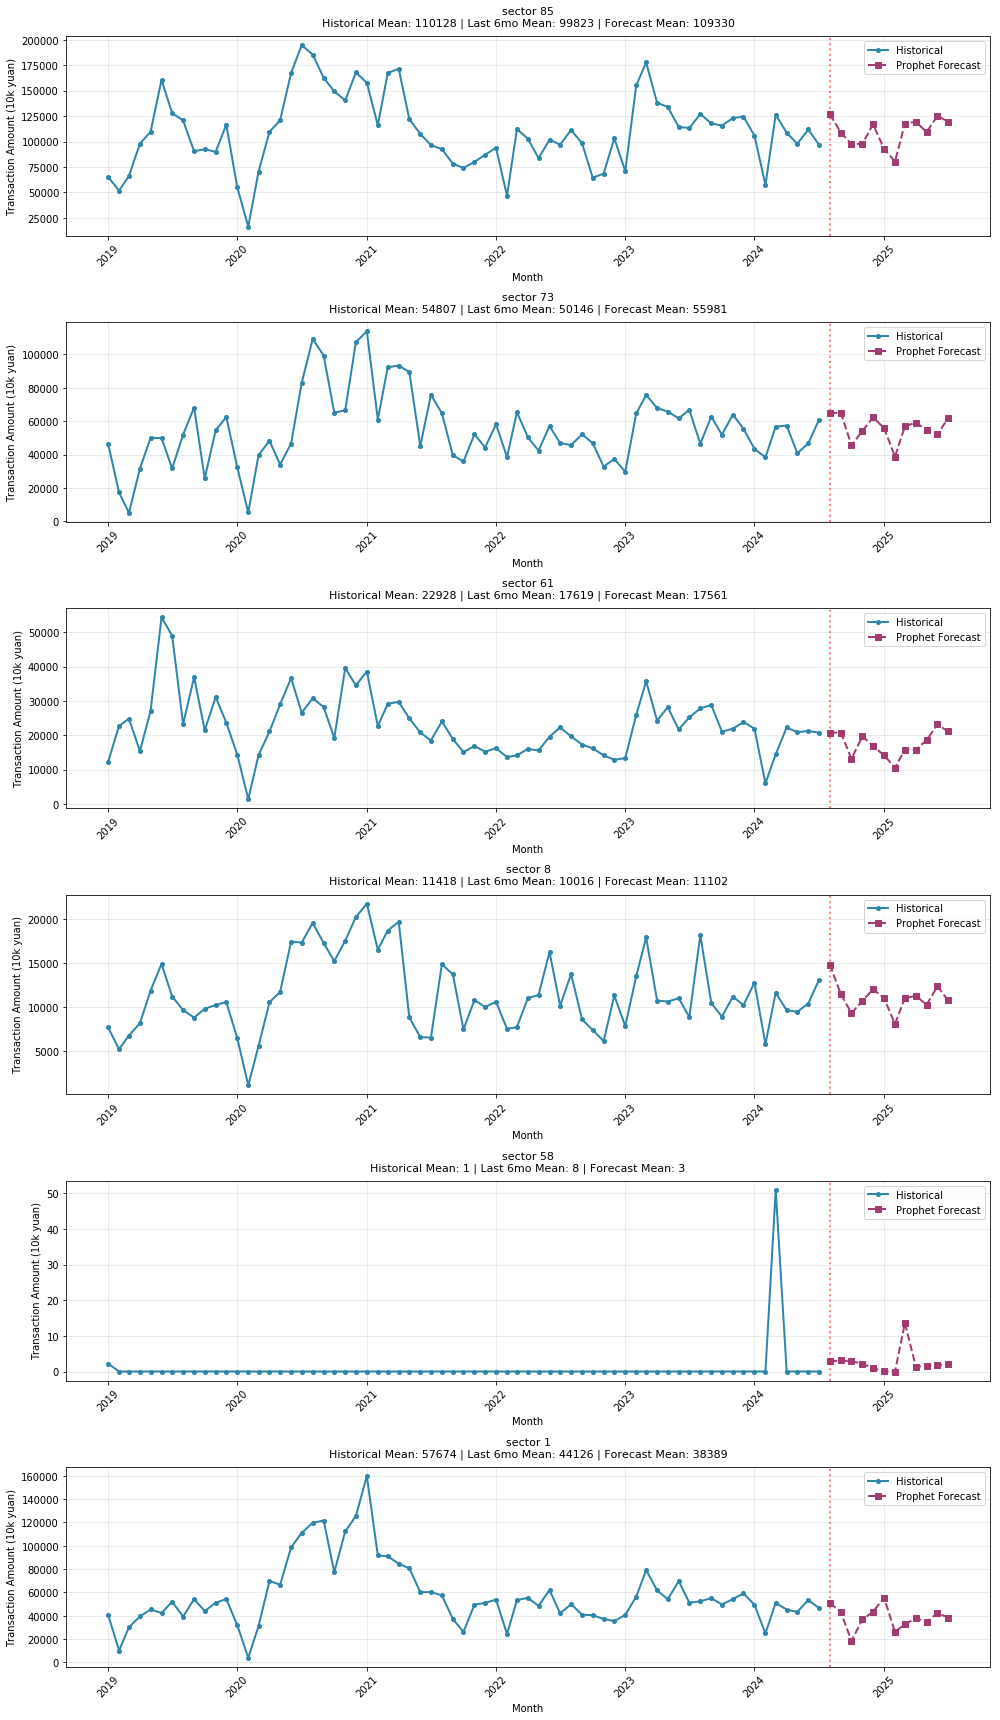


VISUALIZATION ANALYSIS

sector 85:
  Recent 6mo vs Historical: -9.4%
  Forecast vs Recent 6mo: +9.5%
  → Prophet predicting stability

sector 73:
  Recent 6mo vs Historical: -8.5%
  Forecast vs Recent 6mo: +11.6%
  → Prophet predicting trend reversal

sector 61:
  Recent 6mo vs Historical: -23.2%
  Forecast vs Recent 6mo: -0.3%
  → Prophet predicting stability

sector 8:
  Recent 6mo vs Historical: -12.3%
  Forecast vs Recent 6mo: +10.8%
  → Prophet predicting trend reversal

sector 58:
  Recent 6mo vs Historical: +970.5%
  Forecast vs Recent 6mo: -68.2%
  → Prophet predicting trend reversal

sector 1:
  Recent 6mo vs Historical: -23.5%
  Forecast vs Recent 6mo: -13.0%
  → Prophet continuing downward trend

Visualization saved as: prophet_predictions_visualization.png


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fbprophet import Prophet
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# LOAD DATA
# ============================================================================
train = pd.read_csv('/Users/nikola/Python/KaggleCompetition/data/train/pre_owned_house_transactions.csv')
submission = pd.read_csv('/Users/nikola/Python/KaggleCompetition/output/08_prophet/prophet_submission.csv')

train['month'] = pd.to_datetime(train['month'])

# Parse submission to get predictions by sector and month
def parse_submission_id(id_str):
    parts = id_str.split('_')
    date_str = parts[0]
    sector = '_'.join(parts[1:])
    month = pd.to_datetime(date_str, format='%Y %b')
    return month, sector

submission['month'] = submission['id'].apply(lambda x: parse_submission_id(x)[0])
submission['sector'] = submission['id'].apply(lambda x: parse_submission_id(x)[1])

# ============================================================================
# SELECT SECTORS TO VISUALIZE
# ============================================================================
# Pick diverse sectors: high volume, medium, low, and some with interesting patterns
sector_stats = train.groupby('sector')['amount_pre_owned_house_transactions'].agg([
    'mean', 'std', 'count'
]).sort_values('mean', ascending=False)

selected_sectors = [
    sector_stats.index[0],      # Highest volume
    sector_stats.index[5],      # High-medium
    sector_stats.index[20],     # Medium
    sector_stats.index[40],     # Lower-medium
    sector_stats.index[-1],     # Lowest volume
    'sector 1',                 # For comparison to your check
]

# Remove duplicates
selected_sectors = list(dict.fromkeys(selected_sectors))

print(f"Visualizing {len(selected_sectors)} sectors:")
for s in selected_sectors:
    if s in sector_stats.index:
        print(f"  {s}: mean={sector_stats.loc[s, 'mean']:.0f}, std={sector_stats.loc[s, 'std']:.0f}")

# ============================================================================
# CREATE VISUALIZATIONS
# ============================================================================
fig, axes = plt.subplots(len(selected_sectors), 1, figsize=(14, 4*len(selected_sectors)))
if len(selected_sectors) == 1:
    axes = [axes]

for idx, sector in enumerate(selected_sectors):
    ax = axes[idx]
    
    # Get historical data
    sector_train = train[train['sector'] == sector].copy()
    sector_pred = submission[submission['sector'] == sector].copy()
    
    if len(sector_train) == 0:
        ax.text(0.5, 0.5, f'{sector}\nNo training data', 
                ha='center', va='center', fontsize=14)
        ax.set_title(f'{sector} - No Data')
        continue
    
    # Plot historical data
    ax.plot(sector_train['month'], 
            sector_train['amount_pre_owned_house_transactions'],
            'o-', label='Historical', linewidth=2, markersize=4, color='#2E86AB')
    
    # Plot predictions
    ax.plot(sector_pred['month'],
            sector_pred['new_house_transaction_amount'],
            's--', label='Prophet Forecast', linewidth=2, markersize=6, color='#A23B72')
    
    # Add vertical line at forecast start
    forecast_start = sector_pred['month'].min()
    ax.axvline(x=forecast_start, color='red', linestyle=':', alpha=0.5, linewidth=2)
    
    # Calculate statistics
    hist_mean = sector_train['amount_pre_owned_house_transactions'].mean()
    hist_last_6m = sector_train['amount_pre_owned_house_transactions'].tail(6).mean()
    pred_mean = sector_pred['new_house_transaction_amount'].mean()
    
    # Title with statistics
    ax.set_title(f'{sector}\n' + 
                f'Historical Mean: {hist_mean:.0f} | Last 6mo Mean: {hist_last_6m:.0f} | ' +
                f'Forecast Mean: {pred_mean:.0f}',
                fontsize=11, pad=10)
    
    ax.set_xlabel('Month')
    ax.set_ylabel('Transaction Amount (10k yuan)')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    
    # Format x-axis
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('prophet_predictions_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print("VISUALIZATION ANALYSIS")
print("="*60)

# Analyze trend direction for each sector
for sector in selected_sectors:
    sector_train = train[train['sector'] == sector].copy()
    sector_pred = submission[submission['sector'] == sector].copy()
    
    if len(sector_train) == 0:
        continue
    
    hist_mean = sector_train['amount_pre_owned_house_transactions'].mean()
    recent_mean = sector_train['amount_pre_owned_house_transactions'].tail(6).mean()
    pred_mean = sector_pred['new_house_transaction_amount'].mean()
    
    recent_vs_hist = ((recent_mean - hist_mean) / hist_mean) * 100
    pred_vs_recent = ((pred_mean - recent_mean) / recent_mean) * 100 if recent_mean > 0 else 0
    
    print(f"\n{sector}:")
    print(f"  Recent 6mo vs Historical: {recent_vs_hist:+.1f}%")
    print(f"  Forecast vs Recent 6mo: {pred_vs_recent:+.1f}%")
    
    if recent_vs_hist < -10 and pred_vs_recent < -5:
        print(f"  → Prophet continuing downward trend")
    elif recent_vs_hist > 10 and pred_vs_recent > 5:
        print(f"  → Prophet continuing upward trend")
    elif abs(pred_vs_recent) < 10:
        print(f"  → Prophet predicting stability")
    else:
        print(f"  → Prophet predicting trend reversal")

print("\n" + "="*60)
print("Visualization saved as: prophet_predictions_visualization.png")
print("="*60)